In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from featexp import get_univariate_plots, get_trend_stats
import zipfile
from zipfile import ZipFile
import warnings
import xgboost as xgb
warnings.filterwarnings("ignore")
%matplotlib inline

# Loading Dataset

### Choose Modeling Dataset to Use

In [3]:
def read_model_dataset(chosen, combine_cats = False):
    non_features = ['u_id', 'p_id']
    demo_cols = []
    predictor = ['pur']
    file_name = ""

    if chosen == 0:
        file_name = "minimal_preprocess.csv"
        demo_cols = ['gender', 'age', 'years_in_city', 'married', 'city', 'occ']
    elif chosen == 1:
        file_name = "some_one_hot.csv"
        demo_cols = ['gender', 'age', 'years_in_city', 'married', 'occ_0', 'occ_1', 'occ_10',
               'occ_11', 'occ_12', 'occ_13', 'occ_14', 'occ_15', 'occ_16', 'occ_17',
               'occ_18', 'occ_19', 'occ_2', 'occ_20', 'occ_3', 'occ_4', 'occ_5',
               'occ_6', 'occ_7', 'occ_8', 'occ_9', 'city_A', 'city_B', 'city_C']
    elif chosen == 2:
        file_name = "all_one_hot.csv"
        demo_cols = ['gender', 'married', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4',
               'age_5', 'age_6', 'occ_0', 'occ_1', 'occ_10', 'occ_11', 'occ_12',
               'occ_13', 'occ_14', 'occ_15', 'occ_16', 'occ_17', 'occ_18', 'occ_19',
               'occ_2', 'occ_20', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_7', 'occ_8',
               'occ_9', 'city_0', 'city_1', 'city_2',
               'years_in_city_0', 'years_in_city_1', 'years_in_city_2',
               'years_in_city_3', 'years_in_city_4']
    else:
        file_name = "minimal_preprocess.csv"
        demo_cols = ['gender', 'age', 'years_in_city', 'married', 'city', 'occ']
    
    if combine_cats and chosen != 0:
        modeldf = pd.read_csv("inputs/p_combined_" + file_name)
    else:
        modeldf = pd.read_csv("inputs/" + file_name)
    modeldf = modeldf.drop(non_features, axis = 1)
    # line below removes purchase outliers from modeldf
    # modeldf = modeldf[modeldf["pur"] < modeldf["pur"].quantile(0.99)]
    X = modeldf.drop(predictor, axis = 1)
    y = modeldf[predictor]
    
    return modeldf, X, y, predictor, demo_cols

In [200]:
# minimal_preprocess = 0
# some_one_hot = 1
# all_one_hot = 2
# defaults to minimal_preprocess

modeldf, X, y, predictor, demo_cols = read_model_dataset(1, combine_cats = False)
modeldf.head()

,gender,age,years_in_city,married,pur,occ_0,occ_1,occ_10,occ_11,occ_12,...,p_cat_3_15,p_cat_3_16,p_cat_3_17,p_cat_3_18,p_cat_3_3,p_cat_3_4,p_cat_3_5,p_cat_3_6,p_cat_3_8,p_cat_3_9
0,0,0,2,0,8370,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,0,15200,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,0,1422,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,0,1057,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,6,4,0,7969,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Exploration

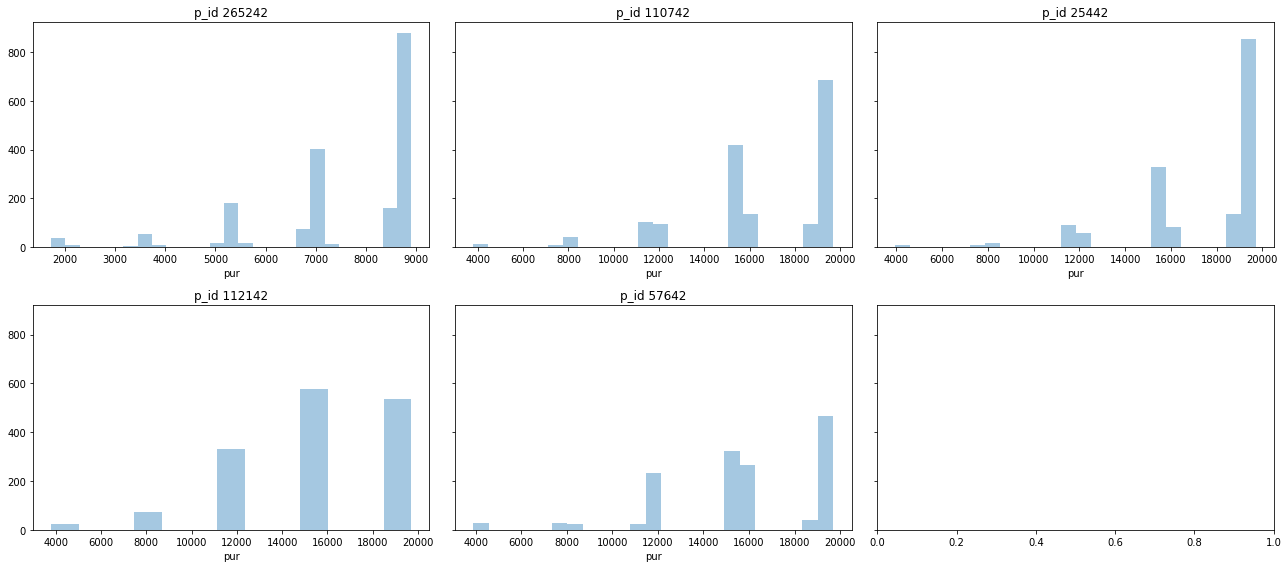

In [87]:
n_cols = 3
n_rows = len(topdfs)//n_cols + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize = (18,4 * n_rows), sharey=True)
for i, df in enumerate(topdfs):
    axs[i//n_cols, i%n_cols].set_title("p_id %d" % top5[i])
    sns.distplot(df['pur'], kde = False, ax = axs[i//n_cols, i%n_cols])
plt.tight_layout()

In [7]:
# splits datasets based on demographics specified
cluster_splits = ['gender', 'age', 'married']

temp = [trimmed_modeldf]
first = True
for split in cluster_splits:
    other_temp = []
    for other in temp:
        other_temp.append([other[other[split] == x] for x in range(min(other[split]), max(other[split]) + 1)])
    if first:
        temp = other_temp[0]
        first = False
    else:
        temp = []
        for other in other_temp:
            for some_other in other:
                if not some_other.empty:
                    temp.append(some_other)

custom_clusters = sorted(temp, key=len)

C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


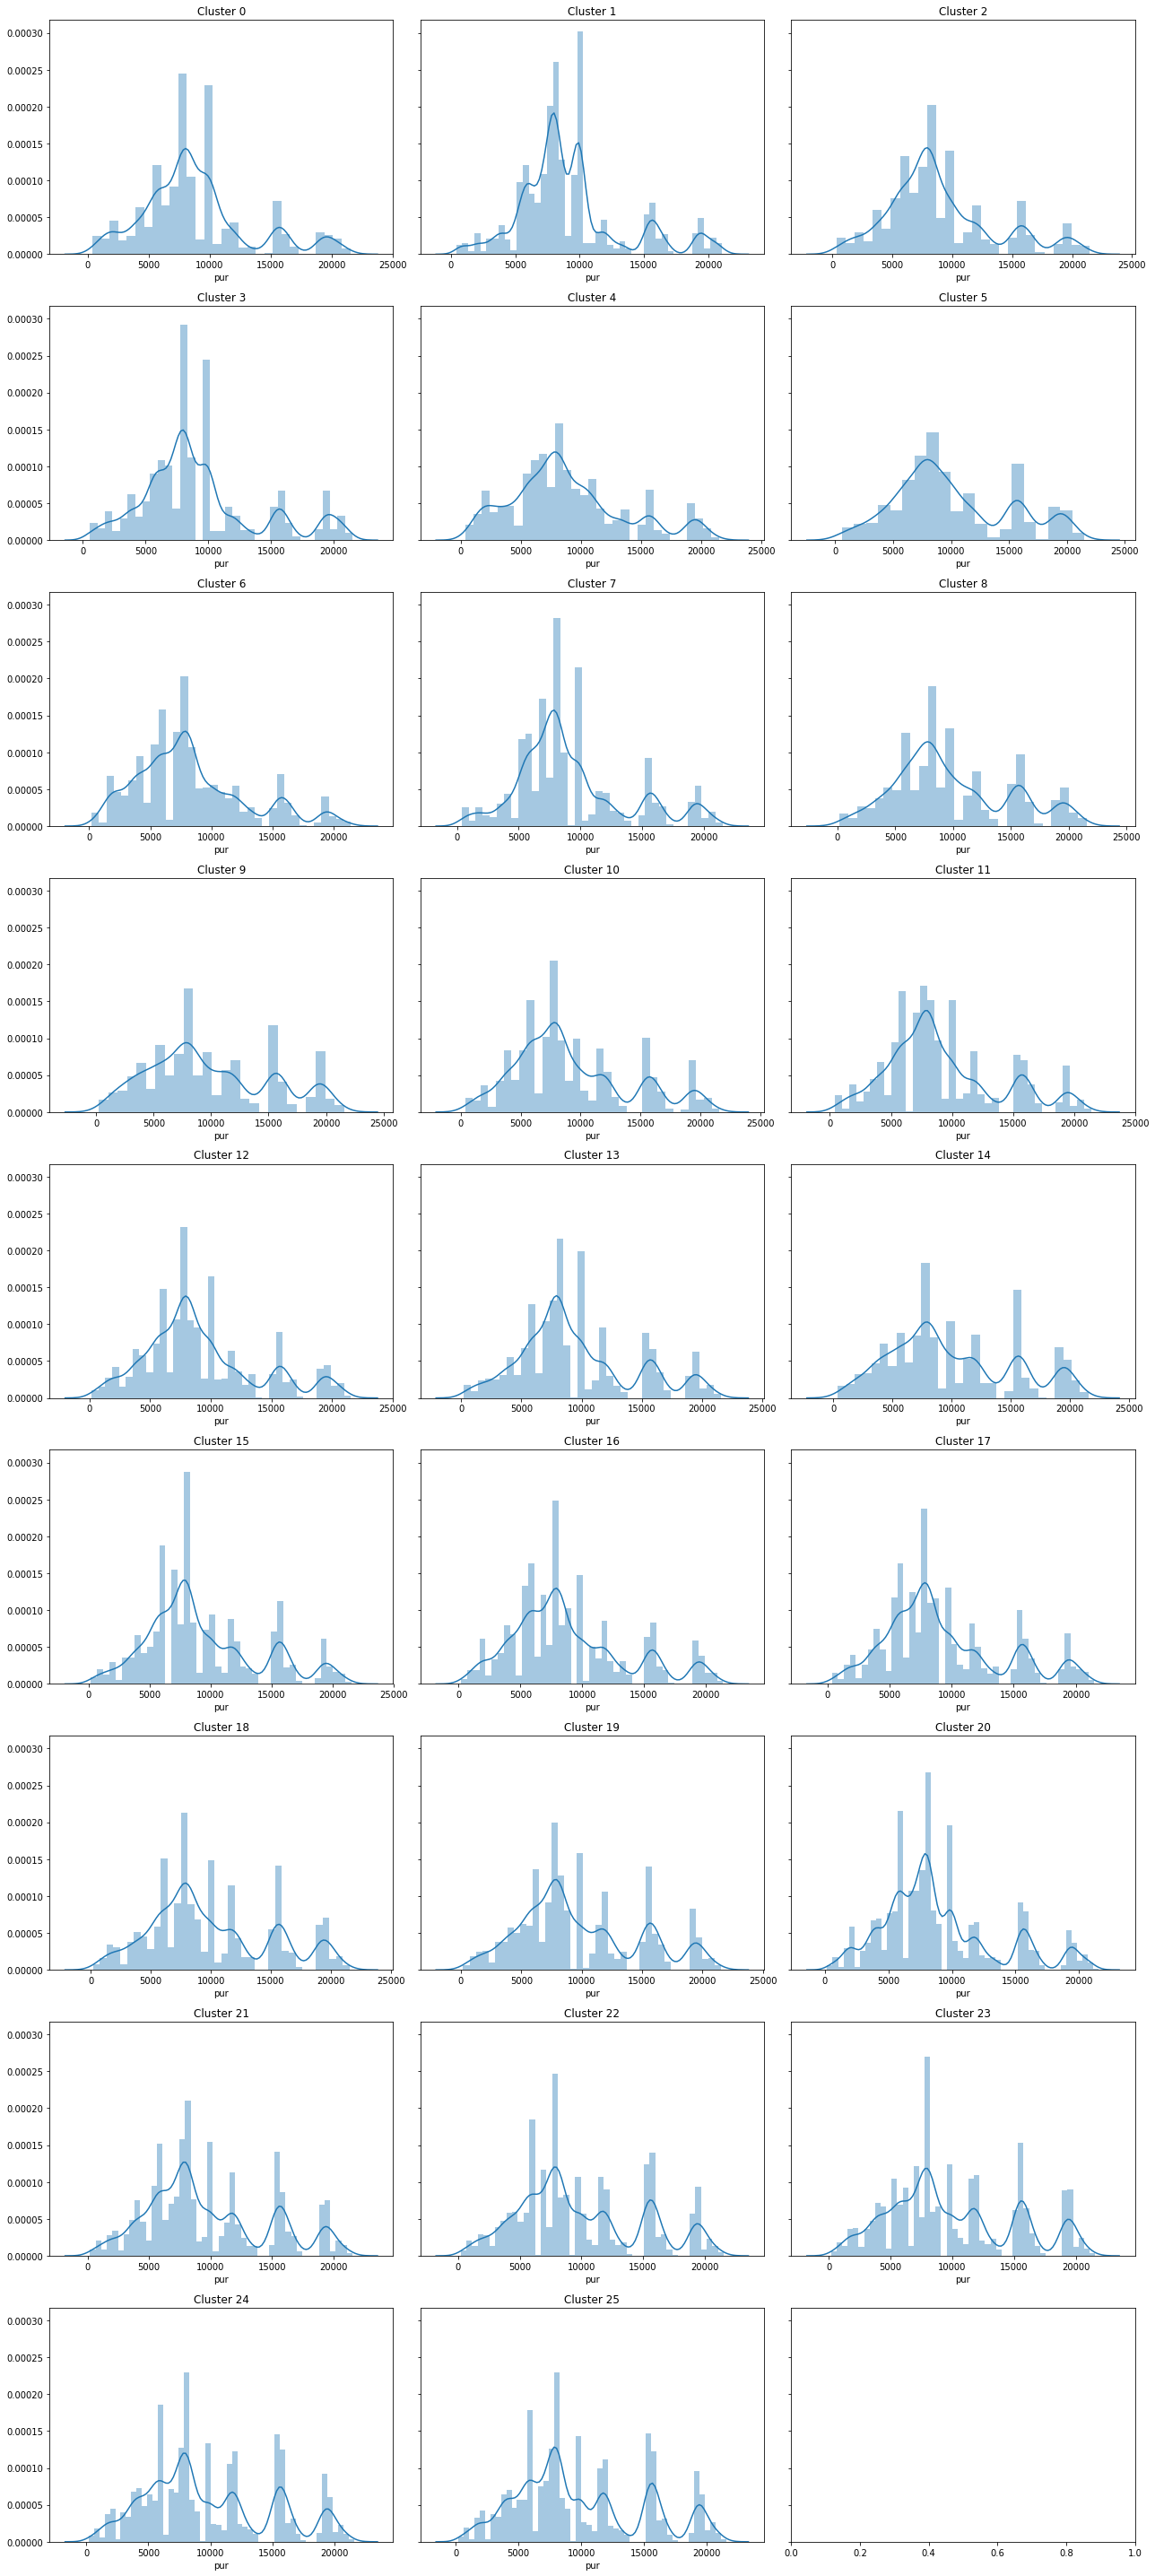

In [8]:
fig, axs = plt.subplots(len(custom_clusters)//3 + 1, 3, figsize = (18,40), sharey=True)
for i, cluster in enumerate(custom_clusters):
    axs[i//3, i%3].set_title("Cluster %d" % i)
    sns.distplot(cluster['pur'], ax = axs[i//3, i%3])
plt.tight_layout()

In [9]:
# splits datasets based on demographics specified
cluster_splits = ['gender', 'age', 'married', 'city']

temp = [modeldf]
first = True
for split in cluster_splits:
    other_temp = []
    for other in temp:
        other_temp.append([other[other[split] == x] for x in range(min(other[split]), max(other[split]) + 1)])
    if first:
        temp = other_temp[0]
        first = False
    else:
        temp = []
        for other in other_temp:
            for some_other in other:
                if not some_other.empty:
                    temp.append(some_other)

custom_clusters = sorted(temp, key=len)

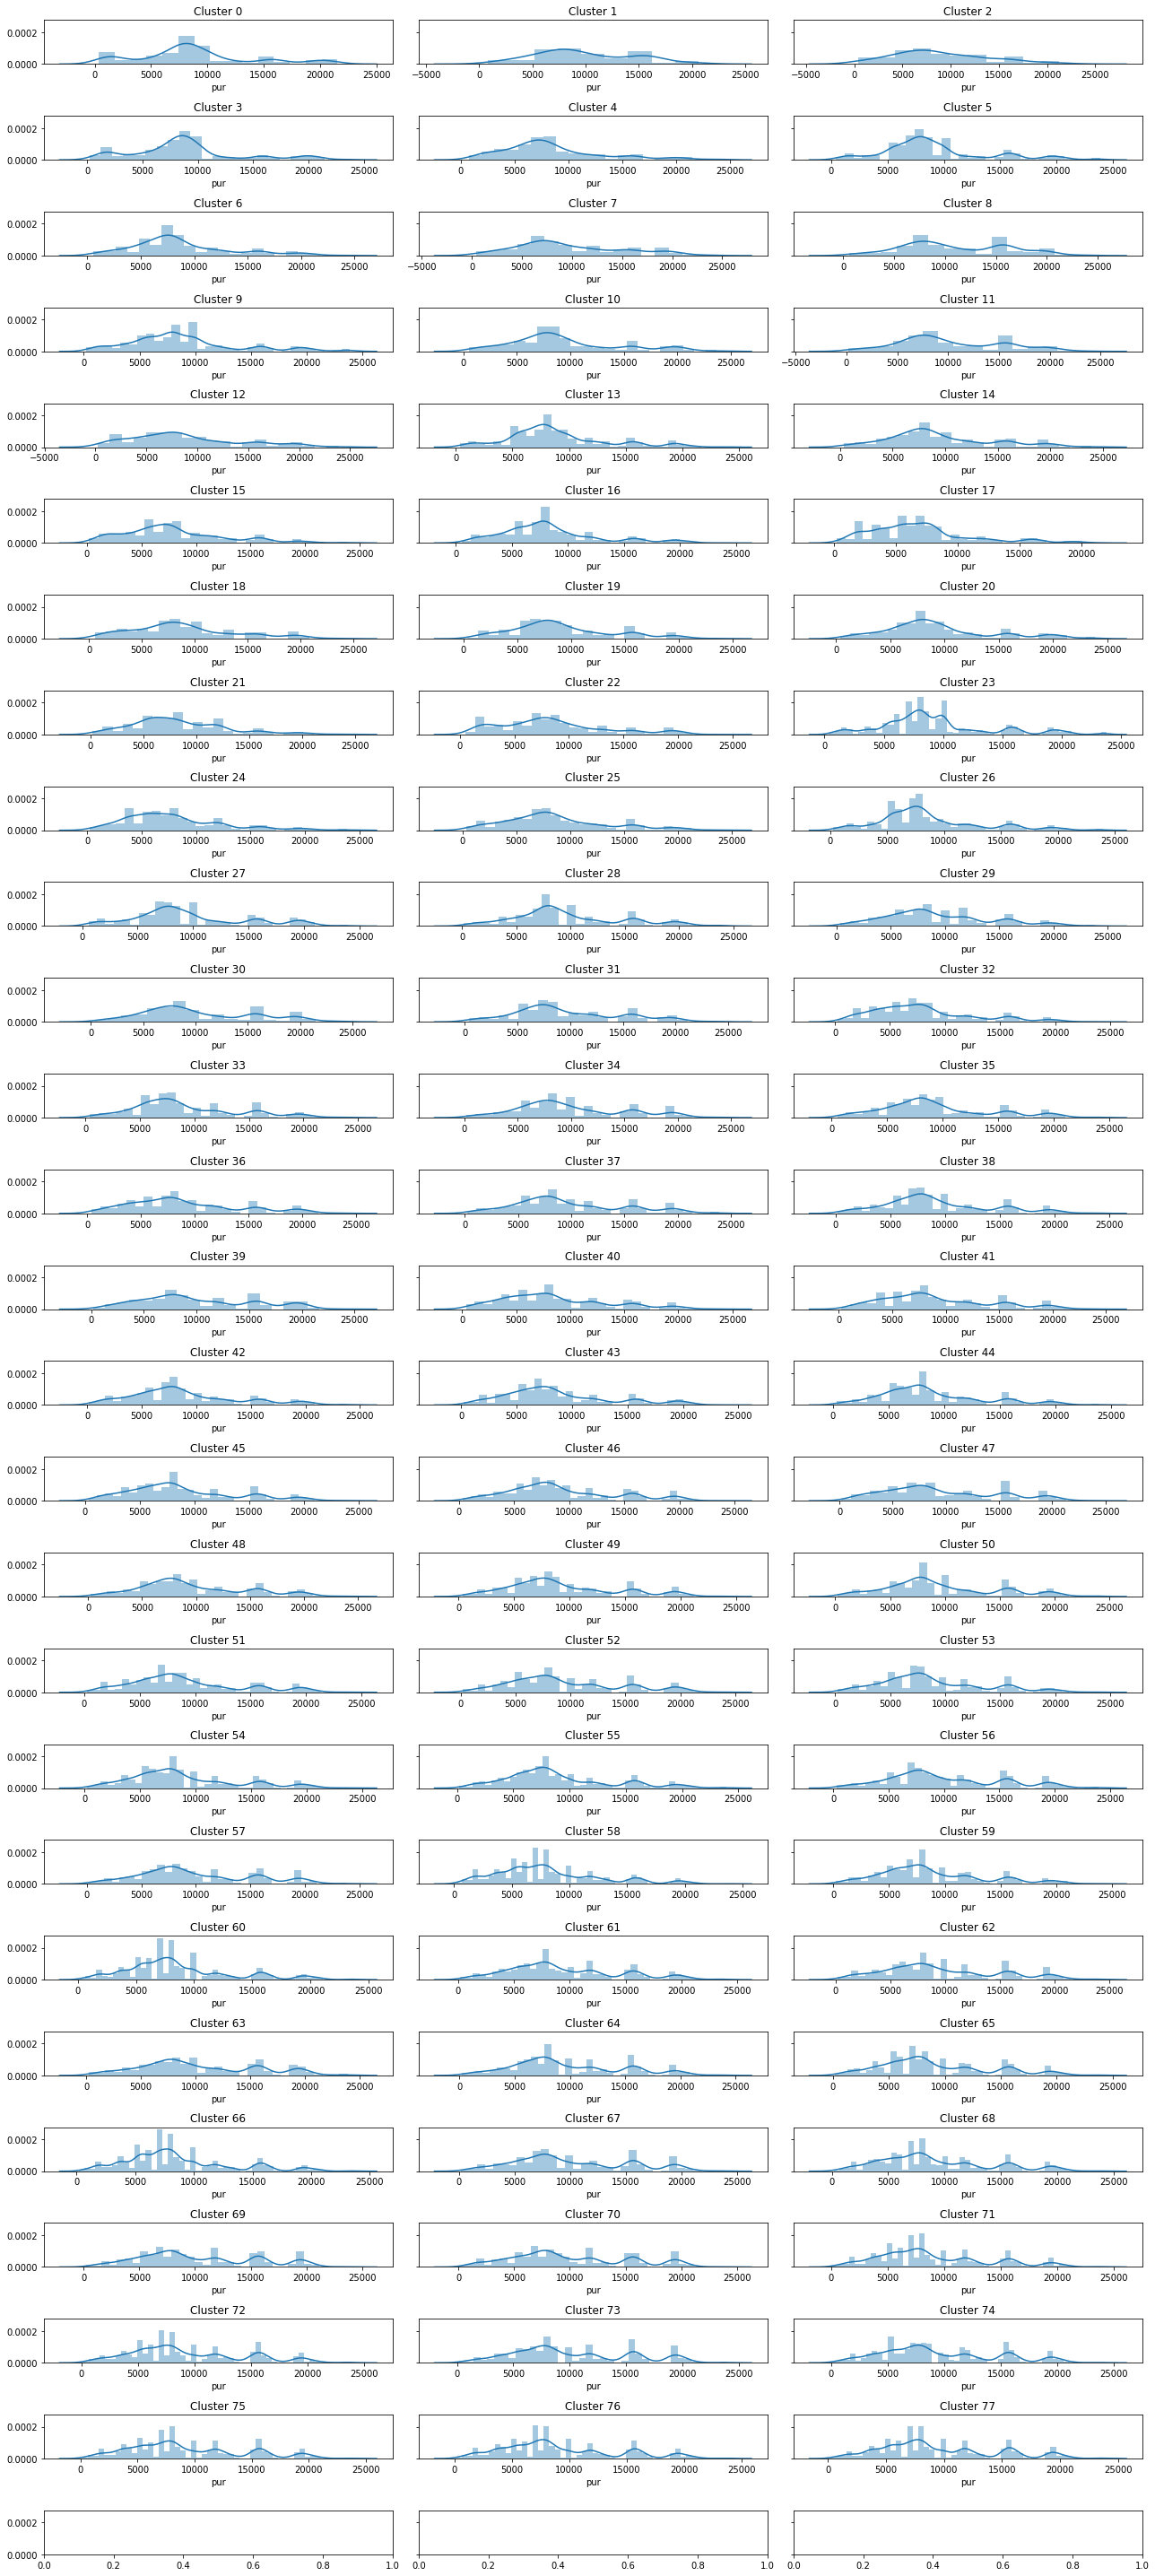

In [10]:
fig, axs = plt.subplots(len(custom_clusters)//3 + 1, 3, figsize = (18,40), sharey=True)
for i, cluster in enumerate(custom_clusters):
    axs[i//3, i%3].set_title("Cluster %d" % i)
    sns.distplot(cluster['pur'], ax = axs[i//3, i%3])
plt.tight_layout()

# Feature Reduction

## Principle Componenet Analysis

In [219]:
def create_pca_modeldf(X, model_cols, per_variance_captured = .95):
    
    all_X = X
    X = X[model_cols]
    X = StandardScaler().fit_transform(X)
    pca = PCA()
    pca.fit(StandardScaler().fit_transform(X))
    plt.subplots(2,1, figsize=(15,5))
    ax1 = plt.subplot(1,2,1)
    plt.plot(pca.explained_variance_ratio_, '-o')
    plt.xlabel("Principal Component")
    plt.ylabel("Pro. Variance Explained")
    ax1 = plt.subplot(1,2,2)
    plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Pro. Variance Explained")
    plt.show()
    
    n_components = np.where(np.cumsum(pca.explained_variance_ratio_)>=per_variance_captured)[0][0] + 1
    print('%0.2f of variance explained by %d principal components' % (per_variance_captured, n_components))
    
    principalComponents = pca.transform(X)[:, 0:n_components]
    X_pca = pd.DataFrame(data = principalComponents, columns = ['pc_' + str(x) for x in range(n_components)])
    pca_cols = X_pca.columns
    X_pca = X_pca.join(all_X.drop(model_cols, axis = 1))
    
    return X_pca, pca_cols

def plot_top3pca(X_pca, color = 'blue'):
    start = 0
    n_cols = 3
    n_rows = 1
    fig, axs = plt.subplots(n_rows, n_cols, figsize = (18,4 * n_rows))
    for i, num in enumerate(range(start, start + 3)):
        axes = axs[i]
        first = 'pc_%d' % num
        second = 'pc_%d' % (num+1)
        axes.scatter(X_pca[first], X_pca[second], color = color)
        axes.set_xlabel(first)
        axes.set_ylabel(second)
    plt.show()
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca['pc_0'], X_pca['pc_1'],  X_pca['pc_2'], color = color)

    ax.set_xlabel("pc_0")
    ax.set_ylabel("pc_1")
    ax.set_zlabel("pc_2")
    plt.show()


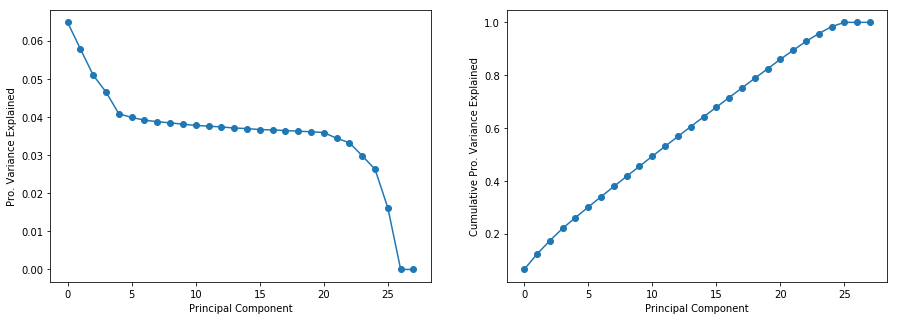

0.95 of variance explained by 24 principal components


,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,p_cat_3_15,p_cat_3_16,p_cat_3_17,p_cat_3_18,p_cat_3_3,p_cat_3_4,p_cat_3_5,p_cat_3_6,p_cat_3_8,p_cat_3_9
0,-3.320668,-1.762538,0.988307,1.951671,0.208613,0.471076,-1.288151,2.805856,0.184317,-0.869306,...,0,0,0,0,0,0,0,0,0,0
1,-3.320668,-1.762538,0.988307,1.951671,0.208613,0.471076,-1.288151,2.805856,0.184317,-0.869306,...,0,0,0,0,0,0,0,0,0,0
2,-3.320668,-1.762538,0.988307,1.951671,0.208613,0.471076,-1.288151,2.805856,0.184317,-0.869306,...,0,0,0,0,0,0,0,0,0,0
3,-3.320668,-1.762538,0.988307,1.951671,0.208613,0.471076,-1.288151,2.805856,0.184317,-0.869306,...,0,0,0,0,0,0,0,0,0,0
4,2.541531,-0.919767,0.610573,-0.790028,-0.398485,-0.129828,1.227845,-0.287828,-0.725582,-0.637972,...,0,0,0,0,0,0,0,0,0,0


In [220]:
X_pca, pca_cols = create_pca_modeldf(X, demo_cols, per_variance_captured = .95)
X_pca.head()

Plotting top 3 PCAs


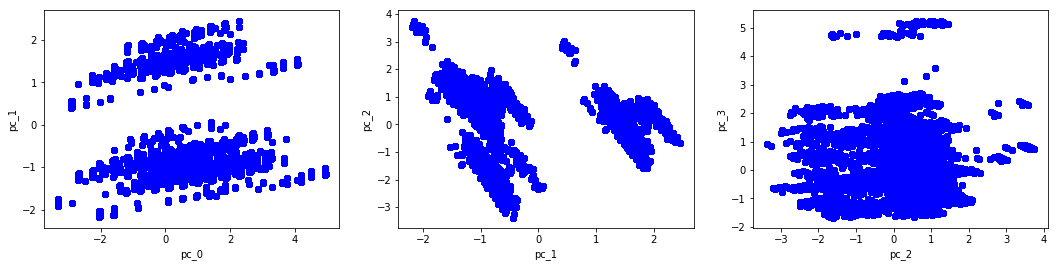

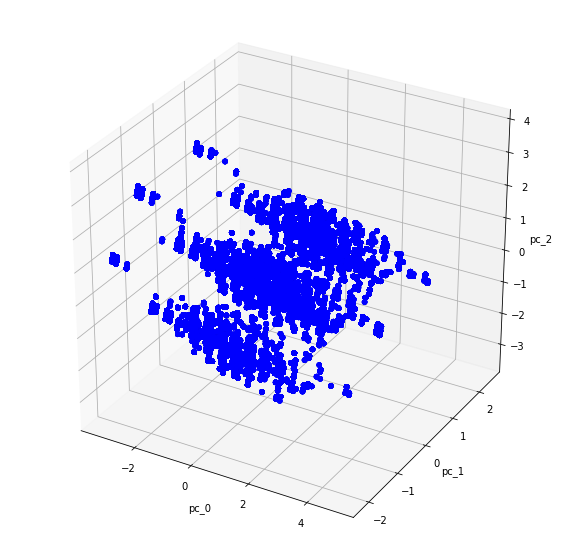

In [38]:
print("Plotting top 3 PCAs")

plot_top3pca(X_pca)

## Factor Analysis

In [221]:
def create_fa_modeldf(X, model_cols, per_variance_captured = .95):
    
    all_X = X
    X = X[model_cols]
    X = StandardScaler().fit_transform(X)
    fa = FactorAnalysis()
    fa.fit(X)
    
    m = fa.components_
    n = fa.noise_variance_
    
    m1 = m**2
    m2 = np.sum(m1, axis = 1)
    
    pvar = (100*m2)/(np.sum(m2)+np.sum(n))
    pvar = pvar/np.cumsum(pvar)[len(pvar) - 1]
    
    plt.subplots(2,1, figsize=(15,5))
    ax1 = plt.subplot(1,2,1)
    plt.plot(pvar, '-o')
    plt.xlabel("Principal Component")
    plt.ylabel("Pro. Variance Explained")
    ax1 = plt.subplot(1,2,2)
    plt.plot(np.cumsum(pvar), '-o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Pro. Variance Explained")
    plt.show()
    
    n_components = np.where(np.cumsum(pvar)>=per_variance_captured)[0][0] + 1
    print('%0.2f of variance explained by %d principal components' % (per_variance_captured, n_components))
    
    components = fa.transform(X)[:, 0:n_components]
    X_fa = pd.DataFrame(data = components, columns = ['f' + str(x) for x in range(n_components)])
    fa_cols = X_fa.columns
    X_fa = X_fa.join(all_X.drop(model_cols, axis = 1))
    
    return X_fa, fa_cols

def plot_top3fa(X_fa, color = 'blue'):
    start = 0
    n_cols = 3
    n_rows = 1
    fig, axs = plt.subplots(n_rows, n_cols, figsize = (18,4 * n_rows))
    for i, num in enumerate(range(start, start + 3)):
        axes = axs[i]
        first = 'f%d' % num
        second = 'f%d' % (num+1)
        axes.scatter(X_fa[first], X_fa[second], color = color)
        axes.set_xlabel(first)
        axes.set_ylabel(second)
    plt.show()
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_fa['f0'], X_fa['f1'],  X_fa['f2'], color = color)

    ax.set_xlabel("f0")
    ax.set_ylabel("f1")
    ax.set_zlabel("f2")
    plt.show()

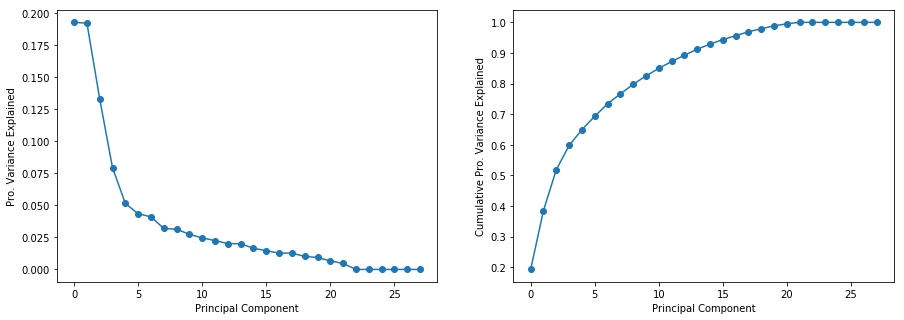

0.95 of variance explained by 17 principal components


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,p_cat_3_15,p_cat_3_16,p_cat_3_17,p_cat_3_18,p_cat_3_3,p_cat_3_4,p_cat_3_5,p_cat_3_6,p_cat_3_8,p_cat_3_9
0,-0.208597,-1.979441,0.694416,0.885650,0.772876,1.407854,-0.463428,-0.160788,-0.240930,0.525191,...,0,0,0,0,0,0,0,0,0,0
1,-0.208597,-1.979441,0.694416,0.885650,0.772876,1.407854,-0.463428,-0.160788,-0.240930,0.525191,...,0,0,0,0,0,0,0,0,0,0
2,-0.208597,-1.979441,0.694416,0.885650,0.772876,1.407854,-0.463428,-0.160788,-0.240930,0.525191,...,0,0,0,0,0,0,0,0,0,0
3,-0.208597,-1.979441,0.694416,0.885650,0.772876,1.407854,-0.463428,-0.160788,-0.240930,0.525191,...,0,0,0,0,0,0,0,0,0,0
4,1.324356,1.013547,-0.024387,-0.432656,-0.236465,-0.174523,-0.124989,-0.153652,-0.326405,0.684448,...,0,0,0,0,0,0,0,0,0,0


In [222]:
X_fa, fa_cols = create_fa_modeldf(X, demo_cols, per_variance_captured = .95)
X_fa.head()

Plotting top 3 FAs


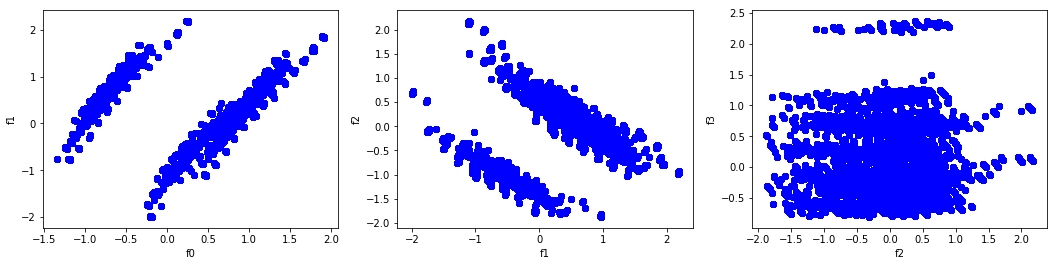

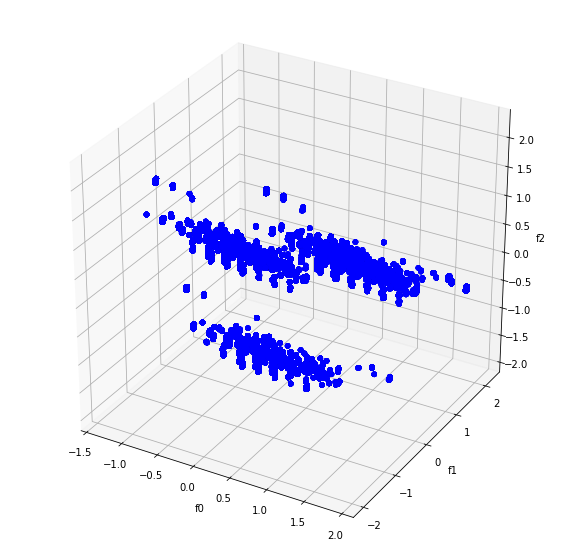

In [39]:
print("Plotting top 3 FAs")

plot_top3fa(X_fa)

# Clustering

## Finding Optimal K

In [41]:
def run_elbow_method(X_frame, demo_cols, max_K = 10): # can change to PCA dataset
    kmeansdf = X_frame[demo_cols]
    distortions = []

    K = range(1, max_K + 1)
    for k in K:
        kmean = KMeans(n_clusters=k, n_init = 10, precompute_distances = True, n_jobs = -1).fit(kmeansdf)
        dist = sum(np.min(cdist(kmeansdf, kmean.cluster_centers_, 'euclidean'), axis=1)) / kmeansdf.shape[0]
        print("Distorition for %d clusters: %0.3f" % (k, dist))
        distortions.append(dist)

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

### Normal Model Dataset

Distorition for 1 clusters: 2.260
Distorition for 2 clusters: 1.975
Distorition for 3 clusters: 1.760
Distorition for 4 clusters: 1.691
Distorition for 5 clusters: 1.635
Distorition for 6 clusters: 1.600
Distorition for 7 clusters: 1.564
Distorition for 8 clusters: 1.518
Distorition for 9 clusters: 1.489
Distorition for 10 clusters: 1.473


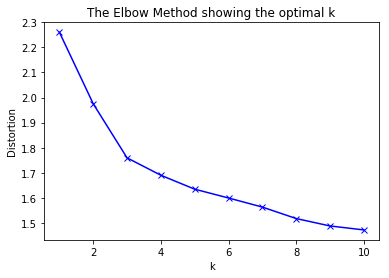

In [142]:
### DON'T RUN UNLESS YOU WANT TO FIND OPTIMAL K FOR K MEANS ###
### TAKES A LONG TIME TO RUN ###

# Model dataframe elbow method
run_elbow_method(X, demo_cols)

### PCA Dataset

Distorition for 1 clusters: 4.924
Distorition for 2 clusters: 4.744
Distorition for 3 clusters: 4.578
Distorition for 4 clusters: 4.530
Distorition for 5 clusters: 4.368
Distorition for 6 clusters: 4.214
Distorition for 7 clusters: 4.018
Distorition for 8 clusters: 3.998
Distorition for 9 clusters: 3.770
Distorition for 10 clusters: 3.638


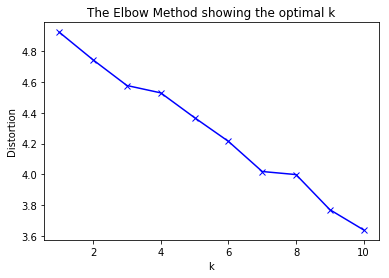

In [43]:
### DON'T RUN UNLESS YOU WANT TO FIND OPTIMAL K FOR K MEANS ###
### TAKES A LONG TIME TO RUN ###

#PCA elbow method
run_elbow_method(X_pca, pca_cols)

### FA Dataset

Distorition for 1 clusters: 1.897
Distorition for 2 clusters: 1.723
Distorition for 3 clusters: 1.568
Distorition for 4 clusters: 1.509
Distorition for 5 clusters: 1.492
Distorition for 6 clusters: 1.439
Distorition for 7 clusters: 1.403
Distorition for 8 clusters: 1.379
Distorition for 9 clusters: 1.345
Distorition for 10 clusters: 1.309


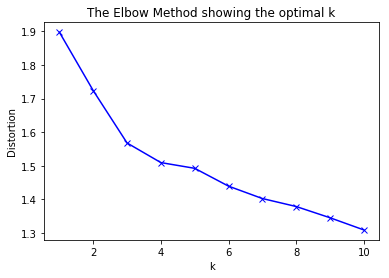

In [42]:
### DON'T RUN UNLESS YOU WANT TO FIND OPTIMAL K FOR K MEANS ###
### TAKES A LONG TIME TO RUN ###

#PCA elbow method
run_elbow_method(X_fa, fa_cols)

## Creating Clustered Dataset

In [223]:
# Generates k-means cluster datasets
# returns whole dataframe with clusters and cluster split dataframes
def create_cluster_modeldfs(X_frame, y, frame_demo_cols, n_clusters = 3):
    kmeansdf = StandardScaler().fit_transform(X_frame[frame_demo_cols])
    
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42, n_init = 20, precompute_distances = True, n_jobs = -1).fit(kmeansdf) # testing shows that 2-3 clussters works the best
    cluster_nums = kmeans.predict(kmeansdf)

    # Single dataset for clusters
    X_cl = pd.DataFrame(cluster_nums, columns = ['cluster_num']).join(X_frame)
    
    # Seperate datasets based on clusters
    temp = X_cl.join(y)
    X_cls = [temp[temp['cluster_num'] == x] for x in range(max(temp['cluster_num']) + 1)]
    X_cls = [cluster.drop('cluster_num', axis = 1) for cluster in X_cls]
    
    # one hot encode cluster numbers
    ranges = pd.unique(pd.Series(X_cl['cluster_num']))
    ranges.sort()
    mapped = ['cluster_num_' + str(x) for x in ranges]
    saved_cluster_num = X_cl['cluster_num']
    X_cl['cluster_num'] = X_cl['cluster_num'].map(dict(zip(ranges, mapped)))
    one_hot = pd.get_dummies(X_cl['cluster_num'])
    #X_cl = X_cl.drop('cluster_num', axis = 1)
    X_cl['cluster_num'] = saved_cluster_num
    X_cl = X_cl.join(one_hot) 
    
    return X_cl, X_cls

In [45]:
def plot_PCA_clusters(X_pca_clusters):
    colors = ['green', 'blue', 'red']
    labels = ['cluster 0', 'cluster 1', 'cluster 2']

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')

    for cluster, color, label in zip(X_pca_clusters, colors, labels):
        ax.scatter(cluster['pc_0'], cluster['pc_1'],  cluster['pc_2'], color = color, label = label)

    ax.set_xlabel("pc_0")
    ax.set_ylabel("pc_1")
    ax.set_zlabel("pc_2")
    ax.legend()
    plt.show()
    
def plot_FA_clusters(X_fa_clusters):
    colors = ['green', 'blue', 'red']
    labels = ['cluster 0', 'cluster 1', 'cluster 2']

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')

    for cluster, color, label in zip(X_fa_clusters, colors, labels):
        ax.scatter(cluster['f0'], cluster['f1'],  cluster['f2'], color = color, label = label)

    ax.set_xlabel("f0")
    ax.set_ylabel("f1")
    ax.set_zlabel("f2")
    ax.legend()
    plt.show()
    

### Normal Model Dataset

In [224]:
try:
    print("Clustering\n")
    X_cluster, X_clusters = create_cluster_modeldfs(X, y, demo_cols, n_clusters = 3)
    print("Done!")
except:
    print ("Create model dataframe first!")

Clustering

Done!


### PCA Dataset

In [225]:
try:
    print("Clustering Using PCAs\n")
    X_pca_cluster, X_pca_clusters = create_cluster_modeldfs(X_pca, y, pca_cols, n_clusters = 3)
    print("Done!")
except:
    print ("Create model dataframe first!")

Clustering Using PCAs

Done!


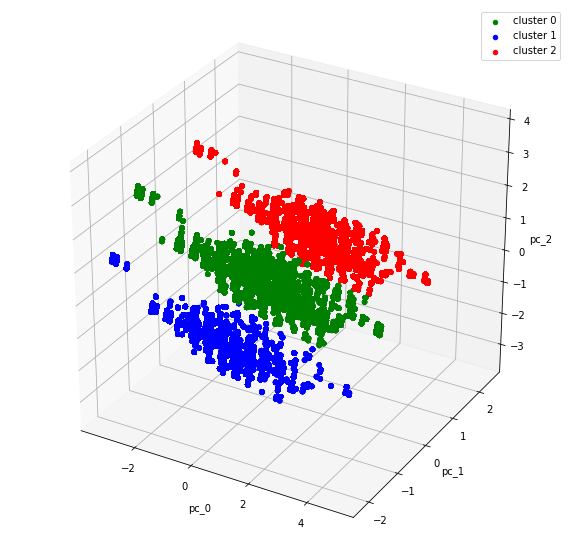

In [103]:
plot_PCA_clusters(X_pca_clusters)

## FA Dataset

In [226]:
try:
    print("Clustering Using FA\n")
    X_fa_cluster, X_fa_clusters = create_cluster_modeldfs(X_fa, y, fa_cols, n_clusters = 3)
    print("Done!")
except:
    print ("Create model dataframe first!")

Clustering Using FA

Done!


Plotting clusters for top 3 FAs


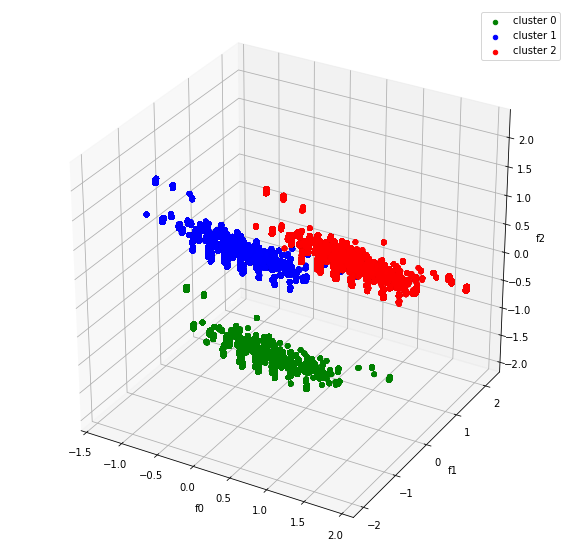

In [82]:
print("Plotting clusters for top 3 FAs")

plot_FA_clusters(X_fa_clusters)

# Predictive Modeling 

## Creating Training and Test Datasets

In [227]:
# Train and testing data for model dataset
def split_model_data(X, y, scale = False): # can specify different
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=30)
    y_train = np.array(y_train).T.reshape(1, -1)[0]
    y_test = np.array(y_test).T.reshape(1, -1)[0]
    return X_train, X_test, y_train, y_test
def create_dataframe_split(X_data, y_data, scale = False):
    try:
        data_splits = (split_model_data(X_data, y_data, scale = scale))
        print("Dataframe shape:", data_splits[0].shape, data_splits[1].shape, data_splits[2].shape, data_splits[3].shape)      
        return data_splits[0], data_splits[1], data_splits[2], data_splits[3]
    except:
        print ("Create model dataframe first!")
        return [], [], [], []
def create_cluster_dataframe_split(clusters):
    try:
        X_cl_trains = []
        X_cl_tests = [] 
        y_cl_trains = []
        y_cl_tests = []
        for i, clusterdf in enumerate(clusters):
            X_frame = clusterdf.drop(predictor, axis = 1)
            y_frame = clusterdf[predictor]
            X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_frame, y_frame, test_size = 0.25, random_state=30)
            y_cl_train = np.array(y_cl_train).T.reshape(1, -1)[0]
            y_cl_test = np.array(y_cl_test).T.reshape(1, -1)[0]
            X_cl_trains.append(X_cl_train)
            X_cl_tests.append(X_cl_test)
            y_cl_trains.append(y_cl_train)
            y_cl_tests.append(y_cl_test)
            print("Cluster num", i, ":" , X_cl_trains[i].shape, X_cl_tests[i].shape, y_cl_trains[i].shape, y_cl_tests[i].shape)
        return X_cl_trains, X_cl_tests, y_cl_trains, y_cl_tests
    except:
        print ("Create model dataframe first!")
        print("")
        return [], [], [], []
    

In [259]:
try:
    print("Model Dataset")
    X_train, X_test, y_train, y_test = create_dataframe_split(X, y)
except:
    print ("Create model dataframe first!")

try:    
    print("\nPCA Dataset")
    X_pca_train, X_pca_test, y_pca_train, y_pca_test = create_dataframe_split(X_pca, y)
except:
    print ("Create model dataframe first!")

try:    
    print("\nFA Dataset")
    X_fa_train, X_fa_test, y_fa_train, y_fa_test = create_dataframe_split(X_fa, y)
except:
    print ("Create model dataframe first!")    
    
try:
    print("\nCluster Dataset")
    X_cl_train, X_cl_test, y_cl_train, y_cl_test = create_dataframe_split(X_cluster.drop('cluster_num', axis = 1), y)
except:
    print ("Create model dataframe first!")

try:
    print("\nPCA Cluster Dataset")
    X_pca_cl_train, X_pca_cl_test, y_pca_cl_train, y_pca_cl_test = create_dataframe_split(X_pca_cluster.drop('cluster_num', axis = 1), y) 
except:
    print ("Create model dataframe first!")
    
try:
    print("\nFA Cluster Dataset")
    X_fa_cl_train, X_fa_cl_test, y_fa_cl_train, y_fa_cl_test = create_dataframe_split(X_fa_cluster.drop('cluster_num', axis = 1), y) 
except:
    print ("Create model dataframe first!")

#--------------------------------------------------------

try:    
    print("\nSplit Cluster Dataset")
    X_cl_trains, X_cl_tests, y_cl_trains, y_cl_tests = create_cluster_dataframe_split(X_clusters)
except:
    print ("Create model dataframe first!")

try:    
    print("\nSplit PCA Cluster Dataset")
    X_pca_cl_trains, X_pca_cl_tests, y_pca_cl_trains, y_pca_cl_tests = create_cluster_dataframe_split(X_pca_clusters)
except:
    print ("Create model dataframe first!")
    
try:    
    print("\nSplit FA Cluster Dataset")
    X_fa_cl_trains, X_fa_cl_tests, y_fa_cl_trains, y_fa_cl_tests = create_cluster_dataframe_split(X_fa_clusters)
except:
    print ("Create model dataframe first!")

Model Dataset
Dataframe shape: (403182, 80) (134395, 80) (403182,) (134395,)

PCA Dataset
Dataframe shape: (403182, 76) (134395, 76) (403182,) (134395,)

FA Dataset
Dataframe shape: (403182, 69) (134395, 69) (403182,) (134395,)

Cluster Dataset
Dataframe shape: (403182, 84) (134395, 84) (403182,) (134395,)

PCA Cluster Dataset
Dataframe shape: (403182, 79) (134395, 79) (403182,) (134395,)

FA Cluster Dataset
Dataframe shape: (403182, 73) (134395, 73) (403182,) (134395,)

Split Cluster Dataset
Cluster num 0 : (18592, 80) (6198, 80) (18592,) (6198,)
Cluster num 1 : (161874, 80) (53958, 80) (161874,) (53958,)
Cluster num 2 : (222716, 80) (74239, 80) (222716,) (74239,)

Split PCA Cluster Dataset
Cluster num 0 : (57436, 76) (19146, 76) (57436,) (19146,)
Cluster num 1 : (57894, 76) (19298, 76) (57894,) (19298,)
Cluster num 2 : (287852, 76) (95951, 76) (287852,) (95951,)

Split FA Cluster Dataset
Cluster num 0 : (121210, 69) (40404, 69) (121210,) (40404,)
Cluster num 1 : (173493, 69) (57832, 

## Modeling

In [229]:
def linear_reg_data(X_tr, y_tr, X_te, y_te):
    reg = LinearRegression().fit(X_tr, y_tr)
    pred = reg.predict(X_te)
    print("MAE: ", mean_absolute_error(pred, y_te))
    print("RMSE: ", np.sqrt(mean_squared_error(pred, y_te)))
def MLP_data(X_tr, y_tr, X_te, y_te, verbose = False, show_plot = False):  
    mlp = MLPRegressor(activation = 'identity',
                   hidden_layer_sizes = (25, 1),
                   solver = 'adam',
                   learning_rate = 'constant',
                   random_state = 42,
                   batch_size = 3000,
                   verbose = verbose,
                   learning_rate_init = 1).fit(X_tr, y_tr)
    pred = mlp.predict(X_te)
    print("MAE: ", mean_absolute_error(pred, y_te))
    print("RMSE: ", np.sqrt(mean_squared_error(pred, y_te)))
    if show_plot:
        plt.plot(np.sqrt(mlp.loss_curve_))
        plt.xlabel("epoch")
        plt.ylabel("MAE")
        plt.show()
def xgboost_data(X_tr, y_tr, X_te, y_te):
    param = {
        'booster': 'dart',
        'eta': .75,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'grow_policy' : 'depthwise',
        'tree_method' : 'hist',
        'eval_metric': 'rmse',
        'max_depth' : 10,
        'rate_drop': 0.1,
        'skip_drop': 0.5,
        'seed': 42}
    num_round = 30  # the number of training iterations
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dtest = xgb.DMatrix(X_te, label=y_te)

    bst = xgb.train(param, dtrain, num_round)
    pred = bst.predict(dtest, ntree_limit=num_round)
    rmse = np.sqrt(mean_squared_error(pred, y_te))
    print("MAE: ", mean_absolute_error(pred, y_te))
    print("RMSE: ", np.sqrt(mean_squared_error(pred, y_te)))
    return bst, rmse

def xgboost_cluster_data(X_cl_trs, X_cl_tes, y_cl_trs, y_cl_tes):
    param = {
        'booster': 'dart',
        'eta': .75,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'grow_policy' : 'depthwise',
        'tree_method' : 'hist',
        'eval_metric': 'rmse',
        'max_depth' : 10,
        'rate_drop': 0.1,
        'skip_drop': 0.5,
        'seed': 42}
    bsts = []
    num_round = 30  # the number of training iterations
    mean_mae = 0

    for i, X_cl_tr, X_cl_te, y_cl_tr, y_cl_te in zip(range(len(X_cl_trs)), X_cl_trs, X_cl_tes, y_cl_trs, y_cl_tes):
        dtrain = xgb.DMatrix(X_cl_tr, label=y_cl_tr)
        dtest = xgb.DMatrix(X_cl_te, label=y_cl_te)

        bst = xgb.train(param, dtrain, num_round)
        pred = bst.predict(dtest)
        temp_mae = mean_absolute_error(pred, y_cl_te)
        mean_mae = mean_mae + temp_mae
        
        print("MAE for cluster", i, ":", temp_mae)
        print("RMSE for Cluster:", i, ":", np.sqrt(mean_squared_error(pred, y_cl_te)))
        print("")
        bsts.append(bst)
    print("\nAverage MAE for all clusters:", mean_mae/len(X_cl_trs))
    return bsts

def update_best_model(best_bst, best_rmse, best_name, bst, rmse, name):
    if best_rmse == -1 or best_rmse > rmse:
        best_rmse = rmse
        best_bst = bst
        best_name = name
    return best_bst, best_rmse, best_name

def get_best_data(best_name):
    if best_name == 'Model':
        return X
    elif best_name == 'PCA':
        return X_pca
    elif best_name == 'FA':
        return X_fa
    elif best_name == 'Cluster':
        return X_cluster
    elif best_name == 'PCA Cluster':
        return X_pca_cluster
    elif best_name == 'FA Cluster':
        return X_fa_cluster
    return X

### Linear Regression

In [230]:
try:
    print("Model Dataset")
    linear_reg_data(X_train, y_train, X_test, y_test)
except:
    print ("Create model dataframe first!")

try:    
    print("\nPCA Dataset")
    linear_reg_data(X_pca_train, y_pca_train, X_pca_test, y_pca_test)
except:
    print ("Create model dataframe first!")

try:    
    print("\nFA Dataset")
    linear_reg_data(X_fa_train, y_fa_train, X_fa_test, y_fa_test)
except:
    print ("Create model dataframe first!")    
    
try:
    print("\nCluster Dataset")
    linear_reg_data(X_cl_train, y_cl_train, X_cl_test, y_cl_test)
except:
    print ("Create model dataframe first!")

try:    
    print("\nPCA Cluster Dataset")
    linear_reg_data(X_pca_cl_train, y_pca_cl_train, X_pca_cl_test, y_pca_cl_test)
except:
    print ("Create model dataframe first!")
    
try:    
    print("\nFA Cluster Dataset")
    linear_reg_data(X_fa_cl_train, y_fa_cl_train, X_fa_cl_test, y_fa_cl_test)
except:
    print ("Create model dataframe first!")
    

Model Dataset
MAE:  2262.835475417612
RMSE:  2990.954371855573

PCA Dataset
MAE:  2263.3288254771383
RMSE:  2991.4735948970642

FA Dataset
MAE:  2264.3159697161354
RMSE:  2992.258885540102

Cluster Dataset
MAE:  2262.6752139216487
RMSE:  2990.799890574183

PCA Cluster Dataset
MAE:  2262.8558065776256
RMSE:  2990.9975766820176

FA Cluster Dataset
MAE:  2264.0032999739574
RMSE:  2992.1082780589995


In [231]:
try:
    print("\nSplit Cluster Dataset\n-------------")
    for i, X_cl_tr, X_cl_te, y_cl_tr, y_cl_te in zip(range(len(X_cl_trains)), X_cl_trains, X_cl_tests, y_cl_trains, y_cl_tests):
        print("Cluster num:", i)
        linear_reg_data(X_cl_tr, y_cl_tr, X_cl_te, y_cl_te)
        print("")
except:
    print ("Create model dataframe first!")
    
try:
    print("\nSplit PCA Cluster Dataset\n-------------")
    for i, X_cl_tr, X_cl_te, y_cl_tr, y_cl_te in zip(range(len(X_pca_cl_trains)), X_pca_cl_trains, X_pca_cl_tests, y_pca_cl_trains, y_pca_cl_tests):
        print("Cluster num:", i)
        linear_reg_data(X_cl_tr, y_cl_tr, X_cl_te, y_cl_te)
        print("")
except:
    print ("Create model dataframe first!")
    
try:
    print("\nSplit FA Cluster Dataset\n-------------")
    for i, X_cl_tr, X_cl_te, y_cl_tr, y_cl_te in zip(range(len(X_fa_cl_trains)), X_fa_cl_trains, X_fa_cl_tests, y_fa_cl_trains, y_fa_cl_tests):
        print("Cluster num:", i)
        linear_reg_data(X_cl_tr, y_cl_tr, X_cl_te, y_cl_te)
        print("")
except:
    print ("Create model dataframe first!")


Split Cluster Dataset
-------------
Cluster num: 0
MAE:  2135.0795216198776
RMSE:  2823.803718852458

Cluster num: 1
MAE:  2247.717755954284
RMSE:  2969.5367245089856

Cluster num: 2
MAE:  2281.8974258812755
RMSE:  3013.9057745380633


Split PCA Cluster Dataset
-------------
Cluster num: 0
MAE:  2226.389637522198
RMSE:  2943.552088059883

Cluster num: 1
MAE:  2251.3302673852213
RMSE:  2962.681427073759

Cluster num: 2
MAE:  2274.603370470344
RMSE:  2998.717524701019


Split FA Cluster Dataset
-------------
Cluster num: 0
MAE:  2252.879360644986
RMSE:  2992.831420506857

Cluster num: 1
MAE:  2241.8097744328397
RMSE:  2957.755893460205

Cluster num: 2
MAE:  2293.3356125553096
RMSE:  3019.0622726309534



### MLP Regression

In [234]:
try:
    print("Model Dataset")
    MLP_data(X_train, y_train, X_test, y_test)
except:
    print ("Create model dataframe first!")

try:    
    print("\nPCA Dataset")
    MLP_data(X_pca_train, y_pca_train, X_pca_test, y_pca_test)
except:
    print ("Create model dataframe first!")

try:    
    print("\nFA Dataset")
    MLP_data(X_fa_train, y_fa_train, X_fa_test, y_fa_test)
except:
    print ("Create model dataframe first!")    
    
try:
    print("\nCluster Dataset")
    MLP_data(X_cl_train, y_cl_train, X_cl_test, y_cl_test)

except:
    print ("Create model dataframe first!")

try:    
    print("\nPCA Cluster Dataset")
    MLP_data(X_pca_cl_train, y_pca_cl_train, X_pca_cl_test, y_pca_cl_test)
except:
    print ("Create model dataframe first!")
    
try:    
    print("\nFA Cluster Dataset")
    MLP_data(X_fa_cl_train, y_fa_cl_train, X_fa_cl_test, y_fa_cl_test)
except:
    print ("Create model dataframe first!") 

Model Dataset
MAE:  2246.6227078802553
RMSE:  3029.516435437649

PCA Dataset
MAE:  2324.077174133776
RMSE:  3031.3322226588807

FA Dataset
MAE:  2258.586969553854
RMSE:  3004.188170814923

Cluster Dataset
MAE:  2241.540325635304
RMSE:  3021.913035733147

PCA Cluster Dataset
MAE:  2301.8827606728278
RMSE:  3014.93917705603

FA Cluster Dataset
MAE:  2305.4185400394963
RMSE:  3018.1252728536497


In [235]:
try:
    print("\nSplit Cluster Dataset\n-------------")
    for i, X_cl_tr, X_cl_te, y_cl_tr, y_cl_te in zip(range(len(X_cl_trains)), X_cl_trains, X_cl_tests, y_cl_trains, y_cl_tests):
        print("Cluster num:", i)
        MLP_data(X_cl_tr, y_cl_tr, X_cl_te, y_cl_te)
        print("")
except:
    print ("Create model dataframe first!")
    
try:
    print("\nSplit PCA Cluster Dataset\n-------------")
    for i, X_cl_tr, X_cl_te, y_cl_tr, y_cl_te in zip(range(len(X_pca_cl_trains)), X_pca_cl_trains, X_pca_cl_tests, y_pca_cl_trains, y_pca_cl_tests):
        print("Cluster num:", i)
        MLP_data(X_cl_tr, y_cl_tr, X_cl_te, y_cl_te)
        print("")
except:
    print ("Create model dataframe first!")
    
try:
    print("\nSplit FA Cluster Dataset\n-------------")
    for i, X_cl_tr, X_cl_te, y_cl_tr, y_cl_te in zip(range(len(X_fa_cl_trains)), X_fa_cl_trains, X_fa_cl_tests, y_fa_cl_trains, y_fa_cl_tests):
        print("Cluster num:", i)
        MLP_data(X_cl_tr, y_cl_tr, X_cl_te, y_cl_te)
        print("")
except:
    print ("Create model dataframe first!")


Split Cluster Dataset
-------------
Cluster num: 0
MAE:  2127.7660937863525
RMSE:  2830.764630492819

Cluster num: 1
MAE:  2251.7510280705033
RMSE:  2974.1146729368406

Cluster num: 2
MAE:  2317.2862615650142
RMSE:  3030.0839655565246


Split PCA Cluster Dataset
-------------
Cluster num: 0
MAE:  2253.1129553270735
RMSE:  2964.4549338730008

Cluster num: 1
MAE:  2274.8661208702865
RMSE:  2972.5139128770784

Cluster num: 2
MAE:  2324.2920630778463
RMSE:  3031.4843013216578


Split FA Cluster Dataset
-------------
Cluster num: 0
MAE:  2213.6072154559847
RMSE:  3010.4310532089194

Cluster num: 1
MAE:  2295.8482821645343
RMSE:  3007.329016491799

Cluster num: 2
MAE:  2318.404298350742
RMSE:  3039.7182420250006



### XGBoost Regression

In [233]:
best_bst = xgb.Booster({'nthread': 4})
best_rmse = -1
best_name = ""

try:
    print("Model Dataset")
    bst, rmse = xgboost_data(X_train, y_train, X_test, y_test)
    best_bst, best_rmse, best_name = update_best_model(best_bst, best_rmse, best_name, bst, rmse, "Model")
except:
    print ("Create model dataframe first!")

try:    
    print("\nPCA Dataset")
    bst, rmse = xgboost_data(X_pca_train, y_pca_train, X_pca_test, y_pca_test)
    best_bst, best_rmse, best_name = update_best_model(best_bst, best_rmse, best_name, bst, rmse, "PCA")
except:
    print ("Create model dataframe first!")

try:    
    print("\nFA Dataset")
    bst, rmse = xgboost_data(X_fa_train, y_fa_train, X_fa_test, y_fa_test)
    best_bst, best_rmse, best_name = update_best_model(best_bst, best_rmse, best_name, bst, rmse, "FA")
except:
    print ("Create model dataframe first!")    
    
try:
    print("\nCluster Dataset")
    bst, rmse = xgboost_data(X_cl_train, y_cl_train, X_cl_test, y_cl_test)
    best_bst, best_rmse, best_name = update_best_model(best_bst, best_rmse, best_name, bst, rmse, "Cluster")

except:
    print ("Create model dataframe first!")

try:    
    print("\nPCA Cluster Dataset")
    bst, rmse = xgboost_data(X_pca_cl_train, y_pca_cl_train, X_pca_cl_test, y_pca_cl_test)
    best_bst, best_rmse, best_name = update_best_model(best_bst, best_rmse, best_name, bst, rmse, "PCA Cluster")
except:
    print ("Create model dataframe first!")
    
try:    
    print("\nFA Cluster Dataset")
    bst, rmse = xgboost_data(X_fa_cl_train, y_fa_cl_train, X_fa_cl_test, y_fa_cl_test)
    best_bst, best_rmse, best_name = update_best_model(best_bst, best_rmse, best_name, bst, rmse, "FA Cluster")
except:
    print ("Create model dataframe first!")
    
print("\n--------------------\nBest Dataset:", best_name)
print("Best RMSE:", best_rmse)

Model Dataset
[03:42:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2152.5959621798224
RMSE:  2885.963515566603

PCA Dataset
[03:42:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2141.2540774039203
RMSE:  2879.381052974568

FA Dataset
[03:43:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2135.425510224956
RMSE:  2871.144101988556

Cluster Dataset
[03:43:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2151.82291066721
RMSE:  2884.015527986211

PCA Cluster Dataset
[03:43:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2139.4089815141615
RMSE:  2876.7420883791315

FA Cluster Dataset
[03:44:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2138.8037974298404
RMSE:  2876.230046134074

----------------

In [232]:
best_bsts = []
best_multi_name = ""
best_avg_rmse = -1

try:
    print("Split Cluster Dataset")

    total_rmse = 0
    bsts = []
    for i in range(len(X_cl_trains)):
        print("Cluster", i)
        bst, rmse = xgboost_data(X_cl_trains[i], y_cl_trains[i], X_cl_tests[i], y_cl_tests[i])
        bsts.append(bst)
        total_rmse = total_rmse + rmse

    best_bsts, best_avg_rmse, best_multi_name = update_best_model(best_bsts, best_avg_rmse, best_multi_name, bsts, total_rmse/len(X_cl_trains), "Cluster")  
except:
    print ("Create model dataframe first!")


try:
    print("\nSplit PCA Cluster Dataset")

    total_rmse = 0
    bsts = []
    for i in range(len(X_pca_cl_trains)):
        print("PCA Cluster", i)
        bst, rmse = xgboost_data(X_pca_cl_trains[i], y_pca_cl_trains[i], X_pca_cl_tests[i], y_pca_cl_tests[i])
        bsts.append(bst)
        total_rmse = total_rmse + rmse

    best_bsts, best_avg_rmse, best_multi_name = update_best_model(best_bsts, best_avg_rmse, best_multi_name, bsts, total_rmse/len(X_pca_cl_trains), "PCA Cluster")  
except:
    print ("Create model dataframe first!")

try:
    print("\nSplit FA Cluster Dataset")

    total_rmse = 0
    bsts = []
    for i in range(len(X_fa_cl_trains)):
        print("FA Cluster", i)
        bst, rmse = xgboost_data(X_fa_cl_trains[i], y_fa_cl_trains[i], X_fa_cl_tests[i], y_fa_cl_tests[i])
        bsts.append(bst)
        total_rmse = total_rmse + rmse

    best_bsts, best_avg_rmse, best_multi_name = update_best_model(best_bsts, best_avg_rmse, best_multi_name, bsts, total_rmse/len(X_fa_cl_trains), "PCA Cluster")  
except:
    print ("Create model dataframe first!")

print("\n--------------------\nBest Dataset:", best_multi_name)
print("Best RMSE:", best_avg_rmse)

Split Cluster Dataset
Cluster 0
[03:41:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2059.4955975931666
RMSE:  2827.587036896394
Cluster 1
[03:41:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2128.242067674511
RMSE:  2863.954542366527
Cluster 2
[03:41:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2174.0729667086684
RMSE:  2912.333341305888

Split PCA Cluster Dataset
PCA Cluster 0
[03:41:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2135.6535563742395
RMSE:  2893.0827472517362
PCA Cluster 1
[03:41:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2159.923908547943
RMSE:  2905.157843033307
PCA Cluster 2
[03:41:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2149.0352246149937
RMSE:  2888.27050

# Save Results

## Save XGB Model and Data

In [269]:
def get_data(name, split = False, cluster = False, split_index = 0):
    if split:
        if name in ['Model', 'Cluster']:
            return (X_clusters[split_index].drop(predictor, axis = 1), X_clusters[split_index][predictor])
        elif name in ['PCA', 'PCA Cluster']:
            return (X_pca_clusters[split_index].drop(predictor, axis = 1), X_pca_clusters[split_index][predictor])
        elif name in ['FA', 'FA Cluster']:
            return (X_fa_clusters[split_index].drop(predictor, axis = 1), X_fa_clusters[split_index][predictor])
    elif cluster:
        if name in ['Model', 'Cluster']:
            return X_cluster, y
        elif name in ['PCA', 'PCA Cluster']:
            return X_pca_cluster, y
        elif name in ['FA', 'FA Cluster']:
            return X_fa_cluster, y
    else:
        if name == 'Model':
            return X, y
        elif name == 'PCA':
            return X_pca, y
        elif name == 'FA':
            return X_fa, y
        elif name == 'Cluster':
            return X_cluster.drop('cluster_num', axis = 1), y
        elif name == 'PCA Cluster':
            return X_pca_cluster.drop('cluster_num', axis = 1), y
        elif name == 'FA Cluster':
            return X_fa_cluster.drop('cluster_num', axis = 1), y

def save_model_and_data(bst, name):
    print("Zipping model and data\n----------------")
    with ZipFile('outputs/xgb_model_and_data.zip', 'w', zipfile.ZIP_DEFLATED) as myzip:
        X_data, y = get_data(name) 
        bst.save_model('outputs/xgb_model.bin') # saves model to local disk
        xgb.DMatrix(X_data, label=y).save_binary('outputs/xgb_data.buffer') # saves model data to local disk
        myzip.write('outputs/xgb_data.buffer') # saves model data to zip so it can be saved on github
        myzip.write('outputs/xgb_model.bin')
    print("Done!")
        
def save_multi_model_and_data(bsts, name):
    print("Zipping models and data\n----------------")
    with ZipFile('outputs/xgb_models_and_data.zip', 'w', zipfile.ZIP_DEFLATED) as myzip:
        for i, bst in zip(range(len(bsts)), bsts):
            print("Zipping for Cluster", i)
            X_data, y = get_data(name, split = True, split_index = i)
            bst.save_model('outputs/xgb_model%d.bin' % i) # saves model to local disk
            xgb.DMatrix(X_data, label=y).save_binary('outputs/xgb_data%d.buffer' % i) # saves model data to local disk
            myzip.write('outputs/xgb_data%d.buffer' % i) # saves model data to zip so it can be saved on github
            myzip.write('outputs/xgb_model%d.bin' % i)
    print("----------------\nDone!")

In [270]:
try:
    save_model_and_data(best_bst, best_name)
except:
    print("Run split XGB modeling first!")
print("")
try:
    save_multi_model_and_data(best_bsts, best_multi_name)
except:
    print("Run XGB modeling first!")

Zipping model and data
----------------
Done!

Zipping models and data
----------------
Zipping for Cluster 0
Zipping for Cluster 1
Zipping for Cluster 2
----------------
Done!


## Save User Cluster Assignments

In [238]:
# uses the minimal_preprocess dataset
def write_cluster_dataset(X_cl, name):
    min_df = pd.read_csv("inputs/minimal_preprocess.csv")
    min_demo = ['gender', 'age', 'years_in_city', 'married', 'city', 'occ']
    start = pd.DataFrame(min_df['u_id']).join(min_df['p_id'])
    outcluster = start.join(pd.DataFrame(X_cl['cluster_num'])).join(min_df.drop(['u_id', 'p_id'], axis = 1))
    outcluster.to_csv("outputs/%s.csv" % name, encoding='utf-8', index = False)
    return outcluster

In [253]:
try:
    print("Writing User Cluster Assignments\n------------------")
    cluster_data, y = get_data(best_name, cluster = True)
    write_cluster_dataset(cluster_data, "user_cluster_assignments")
    print("Done!")
except:
    print("Run XGB modeling first!")

print("")  

try:
    print("Writing Multi User Cluster Assignments\n------------------")
    cluster_data, y = get_data(best_multi_name, cluster = True)
    cluster_data['colFromIndex'] = cluster_data.index
    cluster_data = cluster_data.sort_values(['cluster_num', 'colFromIndex']).drop('colFromIndex', axis = 1)
    write_cluster_dataset(cluster_data, "user_multi_cluster_assignments")
    print("Done!")
except:
    print("Run split XGB modeling first!")

Writing User Cluster Assignments
------------------
Done!

Writing Multi User Cluster Assignments
------------------
Done!


[06:11:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


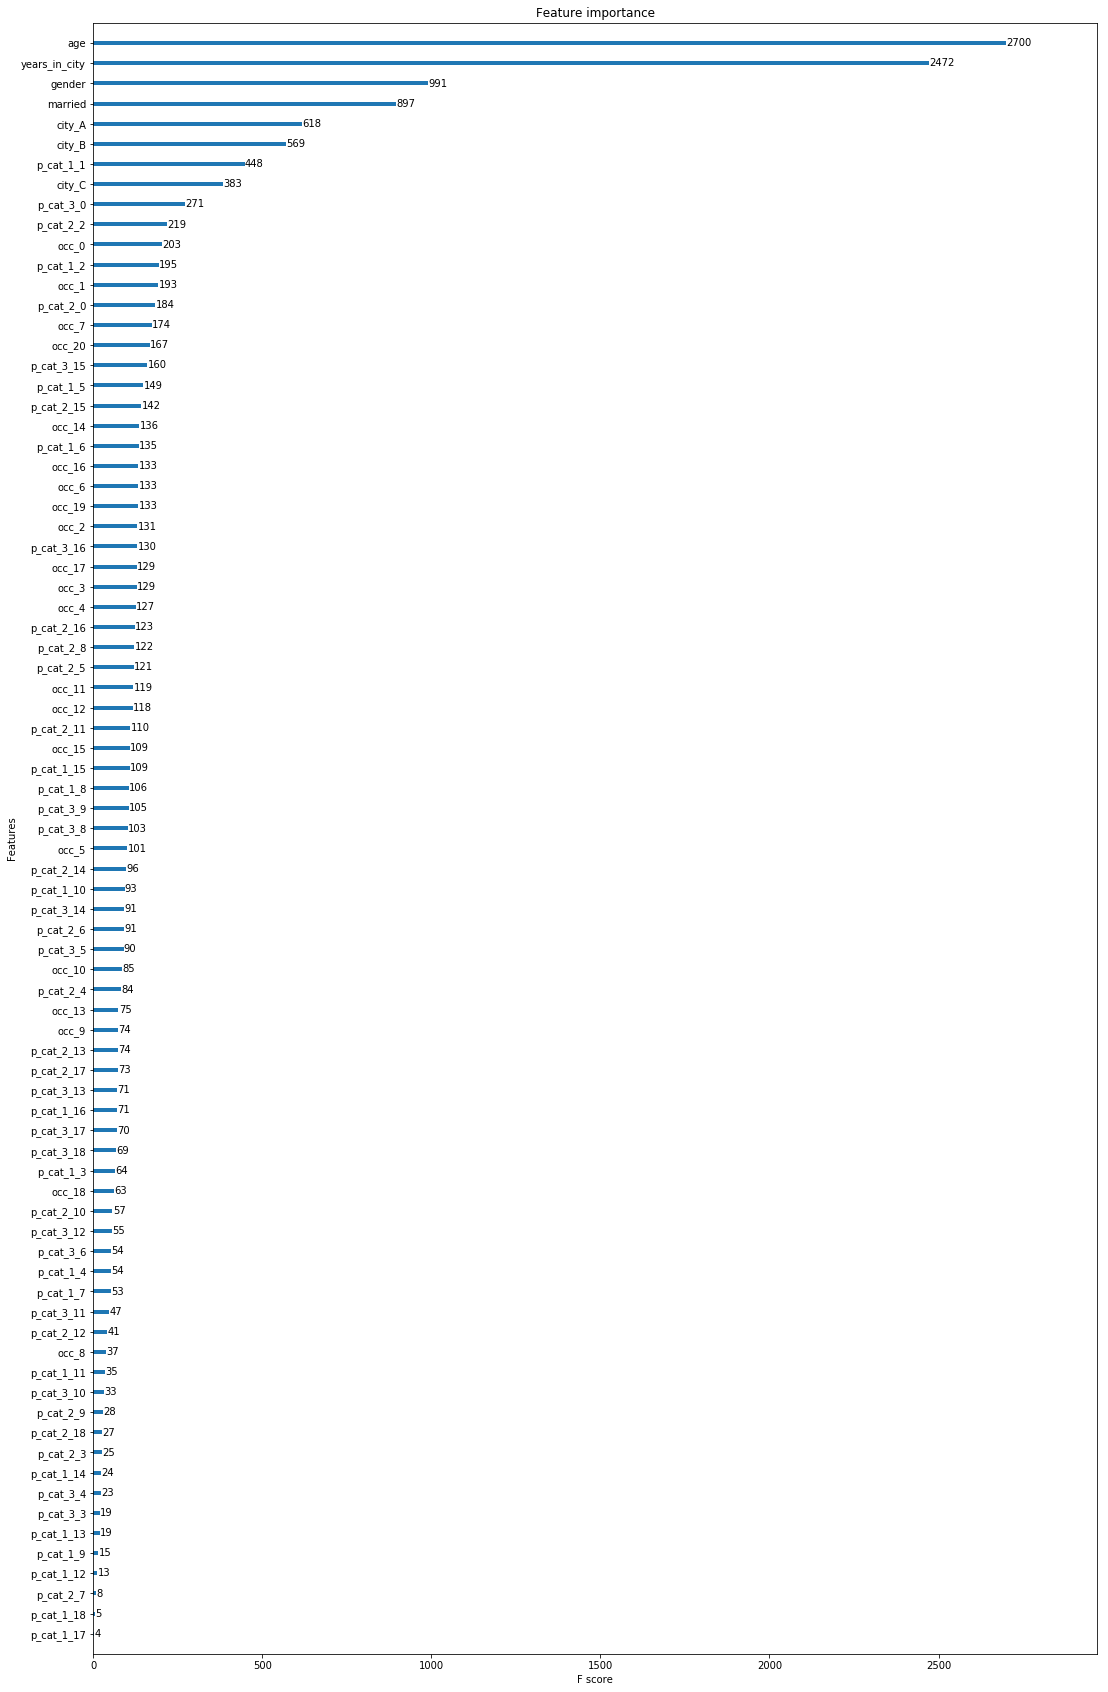

In [173]:
fig, axes = plt.subplots(1, 1, figsize = (18,30))

param = {
        'eta': .75,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'grow_policy' : 'depthwise',
        'tree_method' : 'hist',
        'eval_metric': 'rmse',
        'max_depth' : 10,
        'seed': 42}
num_round = 30  # the number of training iterations

dtrain = xgb.DMatrix(X_train, label=y_train)
bst = xgb.train(param, dtrain, num_round)

xgb.plot_importance(bst, ax = axes, grid = False)
plt.show()


In [282]:
def plot_residuals(bst, X_tr, y_tr):
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    
    predictions_train = bst.predict(dtrain)
    residuals = y_tr - predictions_train

    fig = plt.figure(figsize=(12,4))

    ax1 = fig.add_subplot(121)
    ax1.scatter(predictions_train, residuals)
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Residual")

    ax2 = fig.add_subplot(122)
    ax2.hist(residuals)
    ax2.set_xlabel("Residual")
    ax2.set_ylabel("Frequency")

[01:08:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2152.1324922834347


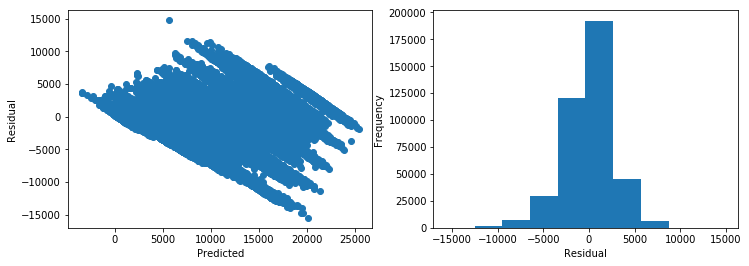

In [120]:
bst = xgboost_data(X_s_pca_train, y_s_pca_train, X_s_pca_test, y_s_pca_test)
plot_residuals(bst, X_s_pca_train, y_s_pca_train)

[11:02:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2135.425510224956
R^2 Score:  0.5078670424360295


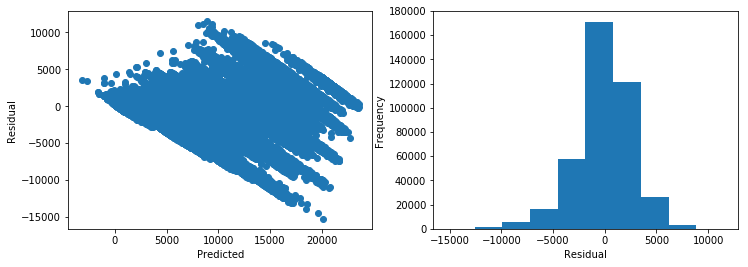

In [340]:
bst = xgboost_data(X_pca_train, y_pca_train, X_pca_test, y_pca_test)
plot_residuals(bst, X_pca_train, y_pca_train)

[01:08:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE for cluster 0 : 2257.26426518299

[01:08:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE for cluster 1 : 2247.909637314214

[01:08:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE for cluster 2 : 2040.1149226474797


Average MAE for all clusters: 2181.7629417148946


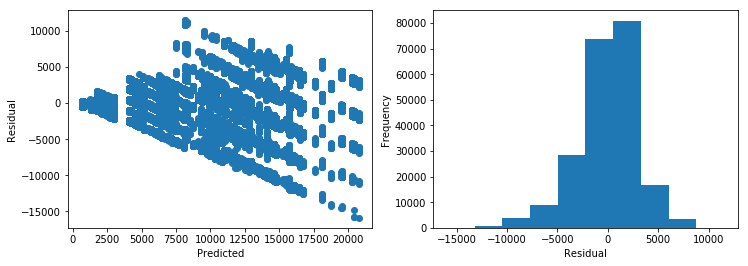

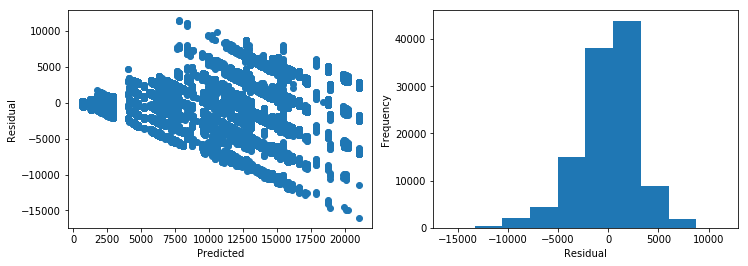

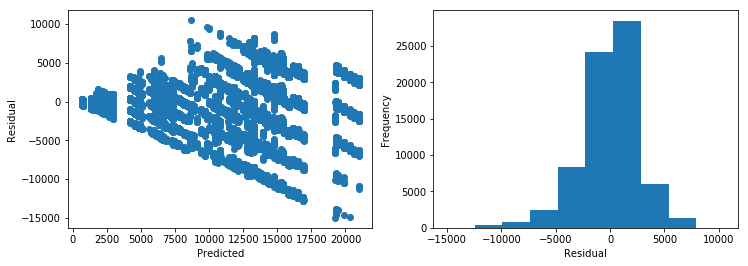

In [121]:
bsts = xgboost_cluster_data(X_cl_trains, X_cl_tests, y_cl_trains, y_cl_tests)
for i, bst, X_cl_tr, y_cl_tr in zip(range(len(bsts)), bsts, X_cl_trains, y_cl_trains):
    plot_residuals(bst, X_cl_tr, y_cl_tr)

### Other Models

#### Gradient Boost Regressor

In [279]:
learning_rates = [1.5]
for learning_rate in learning_rates:
    gb = GradientBoostingRegressor(learning_rate = learning_rate, random_state = 42, max_leaf_nodes = 300, verbose = 2).fit(X_pca_train, y_pca_train)
    pred = gb.predict(X_pca_test)
    print("MAE: ", mean_absolute_error(pred, y_pca_test))
    print("MSE: ", mean_squared_error(pred, y_pca_test))

      Iter       Train Loss   Remaining Time 
         1    16221645.0535            4.78m
         2    13065914.7181            4.55m
         3    10602313.8467            4.44m
         4     9715728.7413            4.16m
         5     9419597.2898            4.02m
         6     9261543.8304            3.91m
         7     9128276.0273            3.87m
         8     9053171.4313            3.78m
         9     8997516.7107            3.73m
        10     8950024.7879            3.64m
        11     8905513.6901            3.66m
        12     8881135.2198            3.67m
        13     8852741.0655            3.64m
        14     8822221.0665            3.64m
        15     8804191.9498            3.58m
        16     8774665.4730            3.63m
        17     8756341.4232            3.58m
        18     8740436.5772            3.50m
        19     8714358.7594            3.46m
        20     8696167.5447            3.42m
        21     8655346.9308            3.37m
        2